# Amazon Comprehend

**Table of Contents**
1. Introduction
    1. NLP (Natural Language Processing)
    2. Amazon Comprehend
2. Setup
4. Implementation
5. Participant Exercise
6. Summary

## 1. Introduction


### A. NLP (Natural Language Processing)

![NLP](img/comprehend-nlp.png)

**NLP (Natural Language Processing)** is a subfield of linguistics, computer science, and artificial intelligence concerned with the interactions between computers and human language, in particular how to program computers to process and analyze large amounts of natural language data.

**Customer challenges with building NLP models:**
* Machine learning skills
* Labeled training data
* Model training effort 
* Model management in production

**Amazon Comprehend**

A fully managed and continuously trained service that discovers insights and relationships in text.

### B. Amazon Comprehend 
**Discover Insights and Relationships in Text**

<!-- <br>
<div>
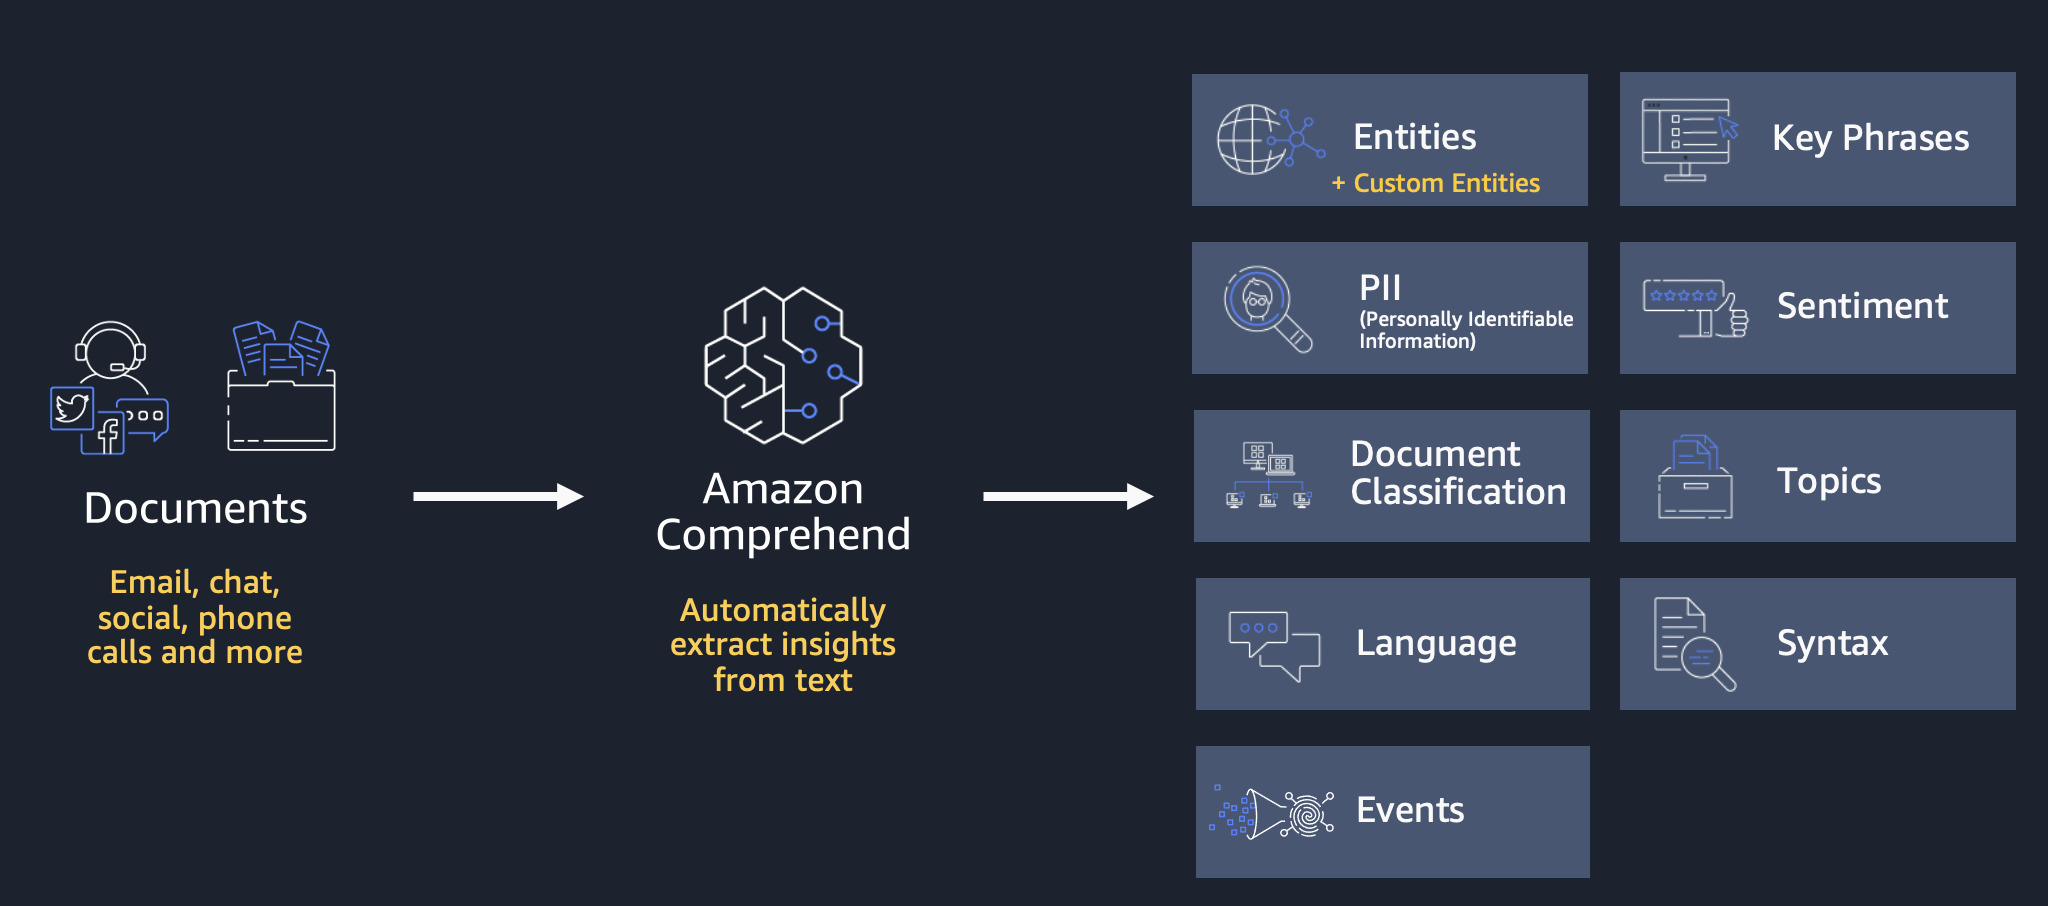
</div>
<br> -->

![NLP](img/comprehend-overview.png)


## 2. Setup 

In [2]:
# set up the libaries and helper functions

from pprint import pprint
import os
import sys
import json
import pandas as pd
import json

import boto3
    
def get_ssm_parameter(parameter_name):
    return boto3.client('ssm').get_parameter(Name=parameter_name)['Parameter']['Value']

def split_s3_uri(uri):
    """return (bucket, key) tuple from s3 uri like 's3://bucket/prefix/file.txt' """
    return uri.replace('s3://','').split('/',1)

def s3_object_from_uri(uri):
    """Initialize a boto3 s3 Object instance from a URI"""
    s3 = boto3.resource('s3')
    return s3.Object(*split_s3_uri(uri))

def s3_contents_from_uri(uri, decode=True):
    """Read contents from S3 object into memory"""
    data = s3_object_from_uri(uri).get()['Body'].read()
    return data.decode() if decode else data

# get document_id from previous notebook - if variable not found try running previous notebook (Textract)
%store -r document_id
document_id

'e898bd39-b591-4fb1-bec5-231b5e2a3b32'

## 3. Implementation 

First, we retreive the Textract response and retreive the text files. To do this, 

- *Step 1*: Retreive the location of the document 

- *Step 2*: Download the Text output from s3

- *Step 3*: Using NLP to derive insights from the Text

- *Step 4*: Save NLP insights into Data store


####  Step 1: Retreive location with DynamoDB of the document 

In [3]:
# In the previous notebook, we set up the DynamoDB table where we stored metadata about the document using a document in DynamoDB
# We can now use that document Id to retreive / store relevant data from this note books

dynamodb = boto3.resource('dynamodb')    
table = dynamodb.Table('document-data')      
resp = table.get_item(
            Key={
                'document_id' : document_id,
            }
        )        
if 'Item' in resp:
    print('DynamoDB Item : {}'.format(json.dumps(resp['Item'],indent=4, sort_keys=True)))
    text_location = resp['Item']['textract_raw_text']
    print('Text file location : {}'.format(text_location))

DynamoDB Item : {
    "document_id": "e898bd39-b591-4fb1-bec5-231b5e2a3b32",
    "src_s3_uri": "s3://ee-assets-prod-us-east-1/modules/b2d6c897c659445583c2edb826183e8e/v1/documents/INSR_ACORD-Property-Loss-Notice-12.05.16_1_pii_00000.pdf",
    "textract_raw_output": "s3://sagemaker-studio-c758d250/textract/e898bd39-b591-4fb1-bec5-231b5e2a3b32.json",
    "textract_raw_text": "s3://sagemaker-studio-c758d250/text/e898bd39-b591-4fb1-bec5-231b5e2a3b32.txt"
}
Text file location : s3://sagemaker-studio-c758d250/text/e898bd39-b591-4fb1-bec5-231b5e2a3b32.txt


#### Step 2 Download Text File

In [6]:
# Now that we have the location of the text for the document, we can use download that file and use it with Amazon Comprehend

document_text = s3_contents_from_uri(text_location)

MAX_CHARS = 500
print(document_text[:MAX_CHARS])

## Uncomment below to view the whole file
print(document_text)


DATE (MM/DD/YYYY)
PROPERTY LOSS NOTICE
03-28-2007
AGENCY
INSURED LOCATION CODE
DATE OF LOSS AND TIME
AM
11-03-2016
11:02:22
PM
PROPERTY/HOME POLICY
CARRIER
NAIC CODE
CONTACT
Alex Serrano
POLICY NUMBER
LINE OF BUSINESS
NAME:
PHONE
383.764.2757
(A/C, No, Ext):
FAX
929-054-2926
FLOOD POLICY
(A/C, No):
E-MAIL
ADDRESS:
caban1894@protonmail.com
CARRIER
NAIC CODE
CODE:
SUBCODE:
AGENCY CUSTOMER ID:
POLICY NUMBER
WIND POLICY
CARRIER
NAIC CODE
POLICY NUMBER
INSURED
NAME OF INSURED (First, Middle, Last)
IN
DATE (MM/DD/YYYY)
PROPERTY LOSS NOTICE
03-28-2007
AGENCY
INSURED LOCATION CODE
DATE OF LOSS AND TIME
AM
11-03-2016
11:02:22
PM
PROPERTY/HOME POLICY
CARRIER
NAIC CODE
CONTACT
Alex Serrano
POLICY NUMBER
LINE OF BUSINESS
NAME:
PHONE
383.764.2757
(A/C, No, Ext):
FAX
929-054-2926
FLOOD POLICY
(A/C, No):
E-MAIL
ADDRESS:
caban1894@protonmail.com
CARRIER
NAIC CODE
CODE:
SUBCODE:
AGENCY CUSTOMER ID:
POLICY NUMBER
WIND POLICY
CARRIER
NAIC CODE
POLICY NUMBER
INSURED
NAME OF INSURED (First, Middle, Last)
I

#### Step 3 : NLP insights with Amazon Comprehend

Now that we have text available, lets try to derive some inights from it.

In this notebook, we will use Amazom Comprehend's pre-trained NLP models which can be used with minimal to no ML experience



##### A) Detect Entities

An entity is a textual reference to the unique name of a real-world object such as people, places, and commercial items, and to precise references to measures such as dates and quantities.

For example, in the text "John moved to 1313 Mockingbird Lane in 2012," "John" might be recognized as a PERSON, "1313 Mockingbird Lane" might be recognized as a LOCATION, and "2012" might be recognized as a DATE.

The following table lists the entity types Amazon Comprehend currently supports (without providing labeled data to train custom models):

![NLP](img/comprehend-standard-entities.png)


In [8]:
comprehend = boto3.client('comprehend')
sync_response = comprehend.detect_entities(
            Text=document_text,
            LanguageCode="en")

# Lets preview a few of the entities detected
MAX_ITEMS = 10

# Each entity also has a score that indicates the level of confidence that Amazon Comprehend has that it correctly detected the entity type. You can filter out the entities with lower scores to reduce the risk of using incorrect detections.
print(json.dumps(sync_response['Entities'][:MAX_ITEMS] , indent = 4, sort_keys = True))

## Uncomment to see all entities detected by Comprehend
print(json.dumps(sync_response , indent = 4, sort_keys = True))

[
    {
        "BeginOffset": 39,
        "EndOffset": 49,
        "Score": 0.8042038679122925,
        "Text": "03-28-2007",
        "Type": "DATE"
    },
    {
        "BeginOffset": 50,
        "EndOffset": 56,
        "Score": 0.6538106203079224,
        "Text": "AGENCY",
        "Type": "ORGANIZATION"
    },
    {
        "BeginOffset": 57,
        "EndOffset": 64,
        "Score": 0.5319849252700806,
        "Text": "INSURED",
        "Type": "ORGANIZATION"
    },
    {
        "BeginOffset": 104,
        "EndOffset": 126,
        "Score": 0.8466582894325256,
        "Text": "11-03-2016\n11:02:22\nPM",
        "Type": "DATE"
    },
    {
        "BeginOffset": 156,
        "EndOffset": 160,
        "Score": 0.8213316798210144,
        "Text": "NAIC",
        "Type": "ORGANIZATION"
    },
    {
        "BeginOffset": 174,
        "EndOffset": 186,
        "Score": 0.9994169473648071,
        "Text": "Alex Serrano",
        "Type": "PERSON"
    },
    {
        "BeginOffset": 230,

In [9]:
# For ease of exploration, Lets review a subset of response data in a tabular format
df = pd.DataFrame(sync_response['Entities'])
df.head()

,Score,Type,Text,BeginOffset,EndOffset
0,0.804204,DATE,03-28-2007,39,49
1,0.653811,ORGANIZATION,AGENCY,50,56
2,0.531985,ORGANIZATION,INSURED,57,64
3,0.846658,DATE,11-03-2016\n11:02:22\nPM,104,126
4,0.821332,ORGANIZATION,NAIC,156,160


##### B) Batch detect entities
Inspects the text of a collection of documents for named entities and returns information about them. 
While the output is similar to detect_entities API, batch_detect_entities helps to run analysis. This is particularly useful when you want to make multiple concurrent requests when you have multiple text snippets to process separately. For example : If you want to process each page of a multi-page document separately, you can consider using this API

In [10]:
comprehend = boto3.client('comprehend')
batch_response = comprehend.batch_detect_entities(
            TextList=[document_text],
            LanguageCode="en")

In [11]:
# Lets reivew our a subset of response data in a tabular format
df = pd.DataFrame(batch_response['ResultList'][0]['Entities'])
df.head()

,Score,Type,Text,BeginOffset,EndOffset
0,0.804204,DATE,03-28-2007,39,49
1,0.653811,ORGANIZATION,AGENCY,50,56
2,0.531985,ORGANIZATION,INSURED,57,64
3,0.846658,DATE,11-03-2016\n11:02:22\nPM,104,126
4,0.821332,ORGANIZATION,NAIC,156,160


##### C) Detect key phrases

A key phrase is a string containing a noun phrase that describes a particular thing. It generally consists of a noun and the modifiers that distinguish it. 

For example, "day" is a noun; "a beautiful day" is a noun phrase that includes an article ("a") and an adjective ("beautiful"). 

In [12]:
comprehend = boto3.client('comprehend')
keyphrase_response = comprehend.detect_key_phrases(
            Text=document_text,
            LanguageCode="en")

Each key phrase includes a score that indicates the level of confidence that Amazon Comprehend has that the string is a noun phrase. You can use the score to determine if the detection has high enough confidence for your application

In [13]:
df = pd.DataFrame(keyphrase_response['KeyPhrases'])
df.sort_values(by='Score', ascending=False).reset_index(drop=True).head()

,Score,Text,BeginOffset,EndOffset
0,0.999305,Forms Boss,2134,2144
1,0.998757,All rights,2040,2050
2,0.997757,more space,1888,1898
3,0.993520,CONTACT,1239,1246
4,0.992908,ACORD\nACORDs,2109,2121


##### D) Detect PII 

A PII (Personally Identifiable Information) entity is a textual reference to personal data that could be used to identify an individual, such as an address, bank account number, or phone number.

You can now use Amazon Comprehend ML capabilities to detect and redact PII in customer emails, support tickets, product reviews, social media, and more. No ML experience required.

For example, you can analyze support tickets and knowledge articles to detect PII entities and redact the text before you index the documents in the search solution. After that, search solutions are free of PII entities in documents. Redacting PII entities helps you protect privacy and comply with local laws and regulations.

In [38]:
comprehend = boto3.client('comprehend')
pii_response = comprehend.detect_pii_entities(
            Text=document_text,
            LanguageCode = "en"
    )

In [39]:
# Lets reivew our a subset of response data in a tabular format

df = pd.DataFrame(pii_response['Entities'])
df.head()

# Notice how detect_pii_entities response is different from the detect_entities API.
# There is no Text column available to protect PII data exposure


,Score,Type,BeginOffset,EndOffset
0,0.999082,DATE_TIME,39,49
1,0.999996,DATE_TIME,104,114
2,0.999972,DATE_TIME,115,126
3,0.999967,NAME,174,186
4,0.999953,PHONE,230,242


#### Step 4 : Save NLP insights to Data store

In [40]:
# Same helper function from previous notebook

def split_s3_uri(uri):
    """return (bucket, key) tuple from s3 uri like 's3://bucket/prefix/file.txt' """
    return uri.replace('s3://','').split('/',1)

def write_to_s3(data, uri):
    boto3.resource('s3').Object(*split_s3_uri(uri)).put(Body=data.encode())


In [41]:
# Retreiving data store resources : DynamoDB table and S3 buckets from previous notebook

%store -r OUTPUT_BUCKET_NAME
OUTPUT_BUCKET_NAME

%store -r DDB_TABLE_NAME
DDB_TABLE_NAME

table = boto3.resource('dynamodb').Table(DDB_TABLE_NAME)



 Similar to the previous notebook, we can need to store our extracted insights into a durable and peristent data store. 
 We can again use S3 to store the full response and DynamoDB to store metadata (such as corresponding s3 location) for the same document_id

In [42]:
# Store pii response as json file on s3
comprehend_pii_s3_uri = f's3://{OUTPUT_BUCKET_NAME}/comprehend/pii-{document_id}.json'
write_to_s3(json.dumps(pii_response['Entities']), comprehend_pii_s3_uri)

# add references to s3 files in dynamodb record for document PII entities

response = table.update_item(
                Key={
                    "document_id": str(document_id),
                },
                UpdateExpression="SET comprehend_pii = :s3URI",
                ExpressionAttributeValues={":s3URI": comprehend_pii_s3_uri},
                ConditionExpression="attribute_exists(#pkey)",
                ExpressionAttributeNames={"#pkey": "document_id"},
                ReturnValues="ALL_NEW",
            )
print(json.dumps(response, indent = 5, sort_keys=True))


{
     "Attributes": {
          "comprehend_pii": "s3://dusc-pipeline-output-test/comprehend/pii-f471bc04-c63e-42b7-a38c-784072093350.json",
          "document_id": "f471bc04-c63e-42b7-a38c-784072093350",
          "src_s3_uri": "s3://ee-assets-prod-us-east-1/modules/b2d6c897c659445583c2edb826183e8e/v1/documents/INSR_ACORD-Property-Loss-Notice-12.05.16_1_pii_00000.pdf",
          "textract_raw_output": "s3://dusc-pipeline-output-test/textract/f471bc04-c63e-42b7-a38c-784072093350.json",
          "textract_raw_text": "s3://dusc-pipeline-output-test/text/f471bc04-c63e-42b7-a38c-784072093350.txt"
     },
     "ResponseMetadata": {
          "HTTPHeaders": {
               "connection": "keep-alive",
               "content-length": "567",
               "content-type": "application/x-amz-json-1.0",
               "date": "Sun, 28 Nov 2021 20:54:43 GMT",
               "server": "Server",
               "x-amz-crc32": "3815248228",
               "x-amzn-requestid": "BNPSKFULVUOTNINFAM6V

In [43]:
import boto3

def update_item(table, key, data):
    return table.update_item(
        Key=key,
        UpdateExpression='SET '+ ', '.join([f'{k} = :{k}' for k in data]),
        ExpressionAttributeValues={f':{k}': v for k,v in data.items()},
        ReturnValues="ALL_NEW"
    )

table = boto3.resource('dynamodb').Table('document-data')

update_item(table, {'document_id': 'bc45ec0a-c338-4cf8-ab6b-ad29424919'}, {'foo':'bar'})

{'Attributes': {'document_id': 'bc45ec0a-c338-4cf8-ab6b-ad29424919',
  'foo': 'bar'},
 'ResponseMetadata': {'RequestId': '2KP5PMAG96INQA3O70A24PQEVJVV4KQNSO5AEMVJF66Q9ASUAAJG',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'server': 'Server',
   'date': 'Sun, 28 Nov 2021 20:54:45 GMT',
   'content-type': 'application/x-amz-json-1.0',
   'content-length': '91',
   'connection': 'keep-alive',
   'x-amzn-requestid': '2KP5PMAG96INQA3O70A24PQEVJVV4KQNSO5AEMVJF66Q9ASUAAJG',
   'x-amz-crc32': '3253076317'},
  'RetryAttempts': 0}}

## 4. (Optional) Participant Exercise

Now try running the async Comprehend API for entity detection and retreiving results. You can use the same document used in this notebook or pull from the documents used in the previous Participant exercise.
Also, look at how you can save the results of the other `detect_entities` and `detect_key_phrases` API calls into S3 and store location related information into DynamoDB.

For reference:
* Comprehend Async API : Refer to [StartEntitiesDetectionJob](https://docs.aws.amazon.com/comprehend/latest/dg/API_StartEntitiesDetectionJob.html)
* Saving Data into DynamoDB and S3 : Refer to the **Save NLP insights to Data store** section in this notebook

## 5. Summary

Amazon Comprehend enables you to examine your documents to gain various insights about their content using a number of pre-trained models.

In addition to what we demoed, you can also explore other <a href="https://docs.aws.amazon.com/comprehend/latest/dg/functionality.html">Amazon Comprehend Text Analysis APIs</a> to detect events, sentiments, the dominant language, and so on.